In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

In [ ]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:22<00:00, 128MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training" #"/content/VOCdevkit"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]

# with open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt') as f:
#     train_lines = f.read().splitlines()

# train_images = train_lines.copy()
# train_masks = train_lines.copy()
# for i in range(len(train_lines)):
#     train_images[i] = os.path.join('/content/VOCdevkit/VOC2012/JPEGImages', train_lines[i] + '.jpg')
#     train_masks[i] = os.path.join('/content/VOCdevkit/VOC2012/SegmentationClass', train_lines[i] + '.png')
# print(train_images)
# print(train_masks)


# NUM_TRAIN_IMAGES = len(train_lines)

# with open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt') as f:
#     val_lines = f.read().splitlines()

# val_images = val_lines.copy()
# val_masks = val_lines.copy()
# for i in range(len(val_lines)):
#     val_images[i] = os.path.join('/content/VOCdevkit/VOC2012/JPEGImages', val_lines[i] + '.jpg')
#     val_masks[i] = os.path.join('/content/VOCdevkit/VOC2012/SegmentationClass', val_lines[i] + '.png')

# NUM_VAL_IMAGES = len(val_lines)

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)


Train Dataset: <BatchDataset shapes: ((4, 224, 224, 3), (4, 224, 224, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, 224, 224, 3), (4, 224, 224, 1)), types: (tf.float32, tf.float32)>


## Rough model for DeepLabV3


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus_1(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    resnet50.summary()
    x = resnet50.get_layer("conv4_block6_2_relu").output
    print("#########################################################")
    print(x.shape)
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    print(input_a.shape)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    print("#########################################################")
    print(input_b.shape)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    print("#########################################################")
    print(input_b.shape)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus_1(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
#model.summary()

In [ ]:
# def DeeplabV3Plus(image_size, num_classes):
#     model_input = keras.Input(shape=(image_size, image_size, 3))

#     model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=False, weights='imagenet', 
#                                             input_tensor=model_input, pooling=None, classes=1000)
    
#     #MNetV3.summary()

#     x = model.get_layer("block_6_expand_relu").output
#     print(x.shape)
#     x = DilatedSpatialPyramidPooling(x)

#     print("x")
#     print(x.shape)
#     input_a = layers.UpSampling2D(
#         size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
#         interpolation="bilinear",
#     )(x)

#     print("input_a")
#     print(input_a.shape)
#     input_b = model.get_layer("block_3_expand_relu").output
#     input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

#     print("input_b")
#     print(input_b.shape)

#     x = layers.Concatenate(axis=-1)([input_a, input_b])
#     x = convolution_block(x)
#     x = convolution_block(x)
#     x = layers.UpSampling2D(
#         size=(image_size // x.shape[1], image_size // x.shape[2]),
#         interpolation="bilinear",
#     )(x)
#     model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
#     return keras.Model(inputs=model_input, outputs=model_output)


# model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
# model.summary()

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
250/250 [==============================] - 24s 73ms/step - loss: 1.5640 - accuracy: 0.5639 - val_loss: 1.7747 - val_accuracy: 0.5091
Epoch 2/25
250/250 [==============================] - 17s 69ms/step - loss: 1.4083 - accuracy: 0.5734 - val_loss: 1.5869 - val_accuracy: 0.4981
Epoch 3/25
146/250 [================>.............] - ETA: 7s - loss: 1.3752 - accuracy: 0.5809

In [ ]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar 

--2021-11-01 15:17:38--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar.1’

VOCtrainval_11-May- 100%[===================>]   1.86G  31.7MB/s    in 60s     

2021-11-01 15:18:38 (31.6 MB/s) - ‘VOCtrainval_11-May-2012.tar.1’ saved [1999639040/1999639040]



In [ ]:
# %%bash
# tar -xvf /content/VOCtrainval_11-May-2012.tar.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


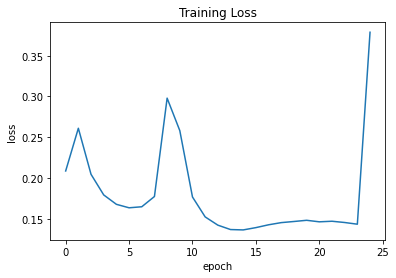

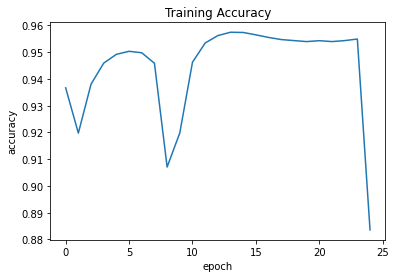

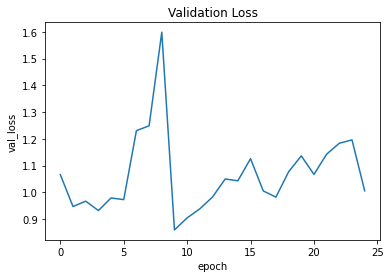

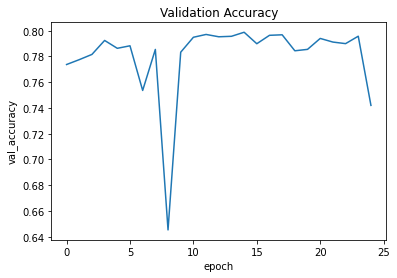

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.outputs

[<KerasTensor: shape=(None, 512, 512, 20) dtype=float32 (created by layer 'conv2d_9')>]